In [5]:
import ee
import pandas as pd

# Authenticate and Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

In [3]:

# Define Amaravati AOI (Small Region)
amaravati_point = ee.Geometry.Point([80.515, 16.540])  # Adjusted to city center
aoi = amaravati_point.buffer(5000)  # 5km buffer for croplands

# Define Time Period
start_date = '2019-01-01'
end_date = '2024-01-01'

# Function to calculate NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

In [7]:

# Load Sentinel-2 Data
s2 = (ee.ImageCollection("COPERNICUS/S2")
      .filterBounds(aoi)
      .filterDate(start_date, end_date)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Removes cloudy images
      .map(add_ndvi)
      .select('NDVI'))

# Load Land Cover Dataset (Dynamic World - 2020)
landcover = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").filterDate('2020-01-01', '2020-12-31').median()

# Extract Cropland Mask
cropland_mask = landcover.select('crops').gt(0.5)  # Crops > 50% probability

In [9]:




# Function to compute monthly NDVI for croplands
def compute_monthly_ndvi(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    # Get Sentinel-2 images for this month
    monthly_images = s2.filterDate(start, end)

    # Check if images exist
    if monthly_images.size().getInfo() == 0:
        print(f"No images for {year}-{month}. Skipping...")
        return None

    # Mask non-croplands
    ndvi_croplands = monthly_images.mean().updateMask(cropland_mask)

    # Compute NDVI for croplands
    ndvi_monthly = ndvi_croplands.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,  # Sentinel-2 works well at 30m
        maxPixels=1e8,
        bestEffort=True
    )

    return ndvi_monthly.get('NDVI')

# Generate NDVI data for croplands from 2019–2024
years = list(range(2019, 2025))
months = list(range(1, 13))

ndvi_data = []
for year in years:
    for month in months:
        try:
            ndvi_value = compute_monthly_ndvi(year, month)
            if ndvi_value is not None:
                ndvi_value = ndvi_value.getInfo()
            ndvi_data.append([year, month, ndvi_value])
        except Exception as e:
            print(f"Error for {year}-{month}: {e}")
            ndvi_data.append([year, month, None])

# Convert to Pandas DataFrame
df = pd.DataFrame(ndvi_data, columns=['Year', 'Month', 'NDVI'])
print(df.head())

# Save as CSV
df.to_csv("amaravati_croplands_ndvi.csv", index=False)
print("NDVI data saved!")


No images for 2019-7. Skipping...
No images for 2019-9. Skipping...
No images for 2019-10. Skipping...
No images for 2020-6. Skipping...
No images for 2020-7. Skipping...
No images for 2020-8. Skipping...
No images for 2020-9. Skipping...
No images for 2021-6. Skipping...
No images for 2021-7. Skipping...
No images for 2021-8. Skipping...
No images for 2021-9. Skipping...
No images for 2021-11. Skipping...
No images for 2022-5. Skipping...
No images for 2022-8. Skipping...
No images for 2022-9. Skipping...
No images for 2023-6. Skipping...
No images for 2023-7. Skipping...
No images for 2023-8. Skipping...
No images for 2023-9. Skipping...
No images for 2024-1. Skipping...
No images for 2024-2. Skipping...
No images for 2024-3. Skipping...
No images for 2024-4. Skipping...
No images for 2024-5. Skipping...
No images for 2024-6. Skipping...
No images for 2024-7. Skipping...
No images for 2024-8. Skipping...
No images for 2024-9. Skipping...
No images for 2024-10. Skipping...
No images f

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,RidgeCV,LassoCV,Lasso,LinearRegression,ElasticNet,ElasticNetCV 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm

C:\Users\hp\AppData\Local\Temp\ipykernel_22672\1547995875.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [19]:
df = pd.read_csv('amaravati_croplands_ndvi.csv')

In [21]:
df

,Year,Month,NDVI
0,2019,1,0.317848
1,2019,2,0.345505
2,2019,3,0.291852
3,2019,4,0.263003
4,2019,5,0.178645
...,...,...,...
67,2024,8,NaN
68,2024,9,NaN
69,2024,10,NaN
70,2024,11,NaN


In [17]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 5977.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
print(df.isnull().sum())

Year      0
Month     0
NDVI     31
dtype: int64


In [33]:
grouped = df.groupby('Month')['NDVI']
ndvi_mean_per_month = grouped.transform('mean')
df['NDVI'] = df['NDVI'].fillna(ndvi_mean_per_month)



In [35]:
df

,Year,Month,NDVI
0,2019,1,0.317848
1,2019,2,0.345505
2,2019,3,0.291852
3,2019,4,0.263003
4,2019,5,0.178645
...,...,...,...
67,2024,8,0.434832
68,2024,9,NaN
69,2024,10,0.382036
70,2024,11,0.355460


In [37]:
print(df.isnull().sum())

Year     0
Month    0
NDVI     6
dtype: int64


In [45]:
df['NDVI'] = df['NDVI'].interpolate(method='linear')


In [47]:
df

,Year,Month,NDVI
0,2019,1,0.317848
1,2019,2,0.345505
2,2019,3,0.291852
3,2019,4,0.263003
4,2019,5,0.178645
...,...,...,...
67,2024,8,0.434832
68,2024,9,0.434832
69,2024,10,0.382036
70,2024,11,0.355460


In [49]:
print(df.isnull().sum())

Year     0
Month    0
NDVI     0
dtype: int64


In [51]:
df.describe()

,Year,Month,NDVI
count,72.00000,72.000000,72.000000
mean,2021.50000,6.500000,0.311874
std,1.71981,3.476278,0.091316
min,2019.00000,1.000000,0.149134
25%,2020.00000,3.750000,0.235906
50%,2021.50000,6.500000,0.293895
75%,2023.00000,9.250000,0.399468
max,2024.00000,12.000000,0.490232


In [59]:
x = df.drop(columns=['NDVI'])

In [61]:
x

,Year,Month
0,2019,1
1,2019,2
2,2019,3
3,2019,4
4,2019,5
...,...,...
67,2024,8
68,2024,9
69,2024,10
70,2024,11


In [63]:
y = df[['NDVI']]

In [65]:
y

,NDVI
0,0.317848
1,0.345505
2,0.291852
3,0.263003
4,0.178645
...,...
67,0.434832
68,0.434832
69,0.382036
70,0.355460


In [67]:
scaler = StandardScaler()

In [69]:
arr = scaler.fit_transform(x)

In [71]:
arr

array([[-1.46385011, -1.59325501],
       [-1.46385011, -1.30357228],
       [-1.46385011, -1.01388955],
       [-1.46385011, -0.72420682],
       [-1.46385011, -0.43452409],
       [-1.46385011, -0.14484136],
       [-1.46385011,  0.14484136],
       [-1.46385011,  0.43452409],
       [-1.46385011,  0.72420682],
       [-1.46385011,  1.01388955],
       [-1.46385011,  1.30357228],
       [-1.46385011,  1.59325501],
       [-0.87831007, -1.59325501],
       [-0.87831007, -1.30357228],
       [-0.87831007, -1.01388955],
       [-0.87831007, -0.72420682],
       [-0.87831007, -0.43452409],
       [-0.87831007, -0.14484136],
       [-0.87831007,  0.14484136],
       [-0.87831007,  0.43452409],
       [-0.87831007,  0.72420682],
       [-0.87831007,  1.01388955],
       [-0.87831007,  1.30357228],
       [-0.87831007,  1.59325501],
       [-0.29277002, -1.59325501],
       [-0.29277002, -1.30357228],
       [-0.29277002, -1.01388955],
       [-0.29277002, -0.72420682],
       [-0.29277002,

In [73]:
df1 = pd.DataFrame(arr)

In [75]:
df1

,0,1
0,-1.46385,-1.593255
1,-1.46385,-1.303572
2,-1.46385,-1.013890
3,-1.46385,-0.724207
4,-1.46385,-0.434524
...,...,...
67,1.46385,0.434524
68,1.46385,0.724207
69,1.46385,1.013890
70,1.46385,1.303572


In [81]:
x_train ,x_test,y_train,y_test = train_test_split(arr,y,test_size=0.25,random_state=223)

In [83]:
x_train

array([[-0.87831007, -1.30357228],
       [ 0.87831007, -0.43452409],
       [-0.29277002, -1.59325501],
       [-0.87831007,  0.43452409],
       [-0.87831007,  1.59325501],
       [-1.46385011, -1.30357228],
       [-1.46385011,  0.14484136],
       [ 1.46385011,  1.01388955],
       [ 1.46385011,  0.43452409],
       [-1.46385011,  1.01388955],
       [ 0.29277002, -1.59325501],
       [ 1.46385011, -0.72420682],
       [-1.46385011, -1.59325501],
       [-1.46385011,  0.43452409],
       [ 0.87831007,  1.01388955],
       [ 0.87831007,  0.14484136],
       [ 1.46385011,  1.59325501],
       [ 0.29277002,  1.01388955],
       [ 0.87831007,  1.59325501],
       [-1.46385011, -1.01388955],
       [ 0.87831007, -1.01388955],
       [ 0.29277002,  1.30357228],
       [-0.29277002, -0.72420682],
       [-1.46385011, -0.14484136],
       [-0.29277002, -0.14484136],
       [ 1.46385011,  0.72420682],
       [ 0.87831007, -1.30357228],
       [ 0.87831007,  0.43452409],
       [-1.46385011,

In [113]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

In [115]:
rf.fit(x_train,y_train)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [117]:
pickle.dump(rf ,open('NDVI_prediction_model.pickle','wb'))

In [119]:
test1 = scaler.transform([[2019,3]])

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [125]:
rf.predict(test1)

array([0.28837957])

In [129]:
rf.score(x_test,y_test)

0.8280538055099302

In [131]:
def adj_r2(x,y):
    r2= rf.score(x,y)
    n = x.shape[0]
    p= x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [133]:
adj_r2(x_test,y_test)

0.8051276462445877

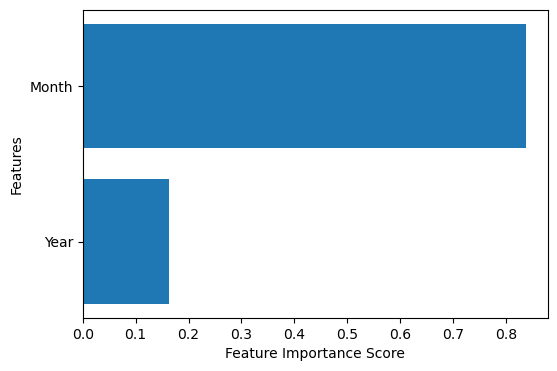

In [135]:

importance = rf.feature_importances_
feature_names = ['Year', 'Month']  # Add other feature names if used

plt.figure(figsize=(6, 4))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()


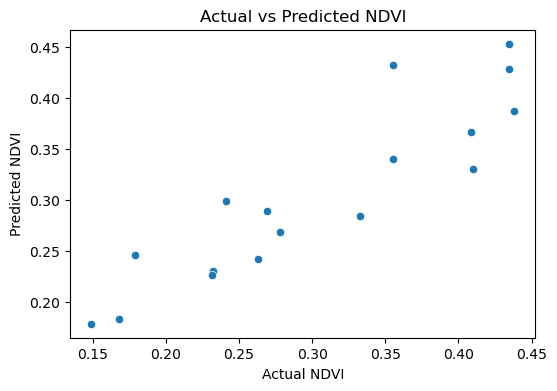

In [152]:
y_pred = rf.predict(x_test).ravel()  # Use .ravel() instead of .flatten()
y_test = y_test.to_numpy().ravel()   # Convert DataFrame to NumPy and make 1D

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title("Actual vs Predicted NDVI")
plt.show()

In [154]:

df.to_csv("ndvi_data.csv", index=False)


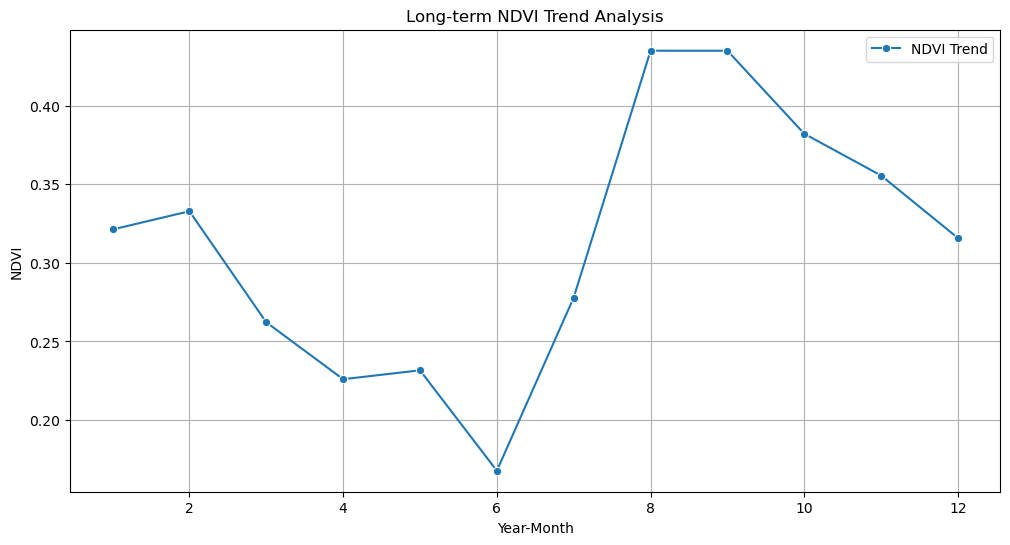

In [180]:
# Aggregate NDVI by year and month
ndvi_trend = df.groupby(['Month']).mean().reset_index()

# Plot NDVI trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=ndvi_trend, x='Month', y='NDVI', marker='o', label='NDVI Trend')
plt.title("Long-term NDVI Trend Analysis")
plt.xlabel("Year-Month")
plt.ylabel("NDVI")
plt.grid(True)
plt.legend()
plt.show()

